In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,Bidirectional
from kerastuner.tuners import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

In [95]:
data=pd.read_csv('Merged_Data.csv',parse_dates=['Tarih'], index_col='Tarih',sep=',',decimal='.',date_format='%Y-%m-%d')
data=data.copy().drop(columns=["Hacim","Fark%","GDP"],axis=1)
#data.dropna(inplace=True)
data.tail(10)


,AdjClose,Açılış,Yüksek,Düşük,M1,Inflation,InterestRate,USD_TRY,BIST100
Tarih,,,,,,,,,
2024-01-03,230.10,235.90,236.00,229.7,5.515378e+09,68.50,44.86,29.69,7412.04
2024-01-04,233.30,230.70,234.30,229.7,5.452040e+09,69.80,44.93,29.75,7547.84
2024-01-05,239.20,233.80,239.20,233.2,5.393797e+09,75.45,45.00,29.82,7628.73
2024-01-06,240.33,235.57,240.83,234.7,5.532444e+09,71.60,45.07,29.84,7692.12
2024-01-07,241.47,237.33,242.47,236.2,5.537031e+09,61.78,45.14,29.86,7755.50
2024-01-08,242.60,239.10,244.10,237.7,5.982992e+09,51.97,45.21,29.88,7818.89
2024-01-09,242.90,243.90,250.50,239.4,6.105518e+09,49.38,45.29,29.87,7736.26
2024-01-10,249.90,242.90,252.25,242.2,6.087428e+09,48.58,45.36,29.95,7874.16
2024-01-11,246.70,250.50,251.50,245.0,6.089273e+09,47.09,45.43,29.96,7895.96


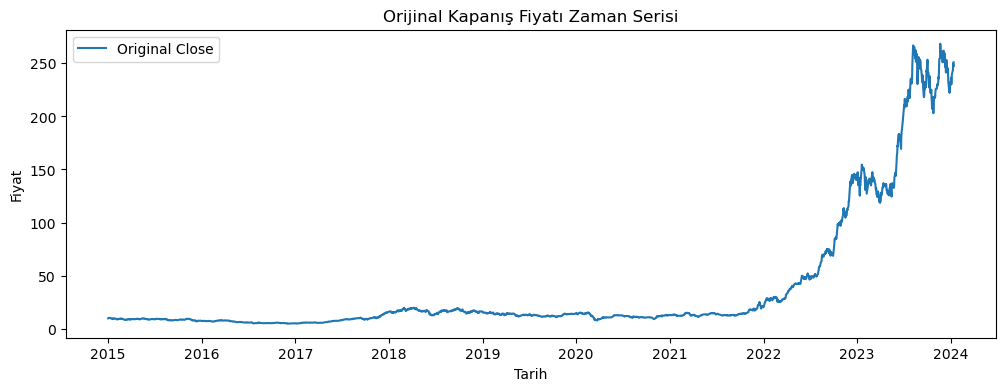

In [96]:
plt.figure(figsize=(12, 4))
plt.plot(data['AdjClose'], label='Original Close')
plt.title("Orijinal Kapanış Fiyatı Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.show()

C:\Users\onugu\AppData\Local\Temp\ipykernel_10656\19082445.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m=data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_10656\19082445.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m=data.last('6M')


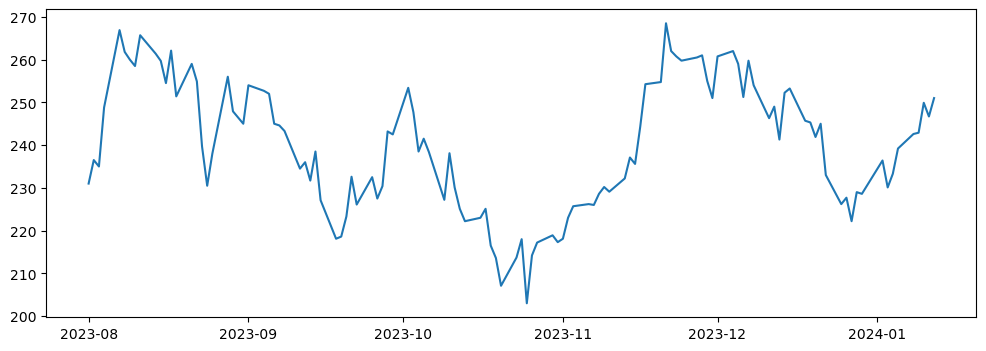

In [97]:
last6m=data.last('6M')
plt.figure(figsize=(12, 4))
plt.plot(last6m['AdjClose'], label='Original Close', )

In [98]:
feature_cols = ['AdjClose']
target_col = 'AdjClose'

X_all = data[feature_cols].values
y_all = data[[target_col]].values


In [99]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X_all)
y_scaled = y_scaler.fit_transform(y_all)


In [100]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 4
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)


In [101]:
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [102]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


c:\Users\onugu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.3384e-04 - val_loss: 8.1003e-04
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6837e-06 - val_loss: 9.6531e-04
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4753e-06 - val_loss: 7.0755e-04
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6247e-06 - val_loss: 6.2942e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8649e-06 - val_loss: 4.0117e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7849e-06 - val_loss: 4.5534e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2484e-06 - val_loss: 4.7585e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5332e-06 - val_loss: 0.0011
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3268e-06 - val_loss: 3.4709e-04
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6828e-06 - val_loss: 8.4838e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3049e-06 - val_loss: 6.8259e-04


In [103]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


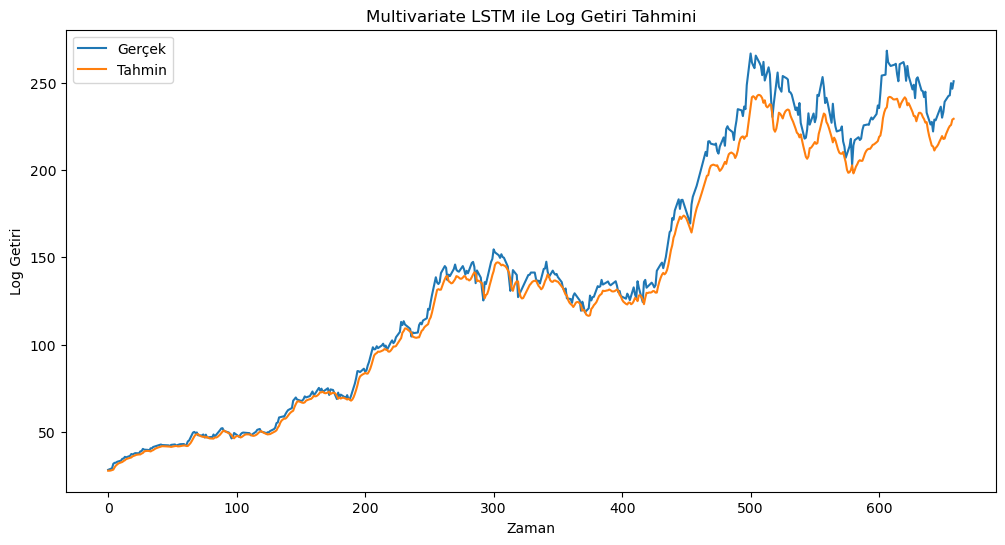

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('Multivariate LSTM ile Log Getiri Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Log Getiri')
plt.legend()
plt.show()


In [105]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
print("Test RMSE:", rmse)


Test RMSE: 10.215223822883521


In [109]:
import copy

baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

feature_importances = []

for i in range(X_test.shape[2]):
    X_test_copy = copy.deepcopy(X_test)
    np.random.shuffle(X_test_copy[:, :, i])  # sadece i. özelliği karıştır
    shuffled_pred = model.predict(X_test_copy)
    shuffled_rmse = np.sqrt(mean_squared_error(y_test, shuffled_pred))
    importance = shuffled_rmse - baseline_rmse
    feature_importances.append((feature_cols[i], importance))

# Önem sırasına göre yazdır
feature_importances.sort(key=lambda x: x[1], reverse=True)
for feat, imp in feature_importances:
    print(f"{feat}: Önem Skoru = {imp:.6f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AdjClose: Önem Skoru = 0.211169
